##Business Understanding

In [ ]:
'''Reentren√© el modelo creando un Pipeline que automatiza
todo el preprocesamiento necesario: primero aplica 
OneHotEncoder para transformar las variables categ√≥ricas
(cut, color, clarity) en variables num√©ricas, luego estandariza 
las variables num√©ricas (carat, depth, table, x, y, z) con 
StandardScaler, y finalmente entrena un RandomForestRegressor. 
Al encapsular todo este flujo en un solo pipeline, se asegura 
que al predecir en producci√≥n (desde Flask), el modelo procese 
autom√°ticamente cualquier entrada en bruto sin errores ni p√©rdidas 
de informaci√≥n, entregando predicciones coherentes y realistas.'''

 

In [10]:
# Paso 1: Importar librer√≠as
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Paso 2: Cargar los datos
df = pd.read_csv('../Diamonds_citt.csv')  # Ajusta la ruta si es necesario

# Eliminar columna extra si existe
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)

# Paso 3: Separar variables
X = df.drop(columns='price')
y = df['price']

# Paso 4: Definir columnas
columnas_categoricas = ['cut', 'color', 'clarity']
columnas_numericas = ['carat', 'depth', 'table', 'x', 'y', 'z']

# Paso 5: Crear preprocesador
preprocesador = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), columnas_categoricas),
    ('num', StandardScaler(), columnas_numericas)
])

# Paso 6: Crear pipeline completo
pipeline = Pipeline(steps=[
    ('preprocesamiento', preprocesador),
    ('modelo', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Paso 7: Entrenar el modelo
pipeline.fit(X, y)

# Paso 8: Guardar el modelo
joblib.dump(pipeline, '../diamantes_api/modelo_diamantes_pipeline.pkl')

print("‚úÖ Modelo entrenado y guardado correctamente como pipeline.")


‚úÖ Modelo entrenado y guardado correctamente como pipeline.


In [ ]:
'''En este proyecto, queremos predecir el precio de los diamantes.
Esto es √∫til para entender c√≥mo distintas caracter√≠sticas como el peso (carat), el color o el tipo de corte
afectan el valor de un diamante en el mercado.'''

## Data Understanding

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Cargamos el archivo CSV (debes haberlo subido previamente en Google Colab)
df = pd.read_csv('./content/Diamonds_citt.csv')

# Mostramos las primeras filas del dataset para ver su estructura
df.head()

# df.info() nos muestra las columnas, tipos de datos y si hay valores nulos
df.info()

# df.describe() entrega estad√≠sticas generales: medias, m√≠nimos, m√°ximos, etc.
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  53940 non-null  int64  
 1   carat       53940 non-null  float64
 2   cut         53940 non-null  object 
 3   color       53940 non-null  object 
 4   clarity     53940 non-null  object 
 5   depth       53940 non-null  float64
 6   table       53940 non-null  float64
 7   price       53940 non-null  int64  
 8   x           53940 non-null  float64
 9   y           53940 non-null  float64
 10  z           53940 non-null  float64
dtypes: float64(6), int64(2), object(3)
memory usage: 4.5+ MB


Unnamed: 0         carat         depth         table         price  \
count  53940.000000  53940.000000  53940.000000  53940.000000  53940.000000   
mean   26970.500000      0.797940     61.749405     57.457184   3932.799722   
std    15571.281097      0.474011      1.432621      2.234491   3989.439738   
min        1.000000      0.200000     43.000000     43.000000    326.000000   
25%    13485.750000      0.400000     61.000000     56.000000    950.000000   
50%    26970.500000      0.700000     61.800000     57.000000   2401.000000   
75%    40455.250000      1.040000     62.500000     59.000000   5324.250000   
max    53940.000000      5.010000     79.000000     95.000000  18823.000000   

                  x             y             z  
count  53940.000000  53940.000000  53940.000000  
mean       5.731157      5.734526      3.538734  
std        1.121761      1.142135      0.705699  
min        0.000000      0.000000      0.000000  
25%        4.710000      4.720000      2.910000  
50%        5.700000      5.710000      3.530000  
75%        6.540000      6.540000      4.040000  
max       10.740000     58.900000     31.800000

## Data Preparation

Eliminar columnas innecesarias y duplicadas

In [5]:
# La columna 'Unnamed: 0' es un √≠ndice repetido que no aporta informaci√≥n, la eliminamos
df.drop(columns=['Unnamed: 0'], inplace=True)

# Revisamos si hay filas duplicadas y las eliminamos para evitar que influyan en el an√°lisis
df.drop_duplicates(inplace=True)

Revisar si hay valores nulos

In [6]:
# Importante: revisamos si hay valores nulos en las columnas
print(df.isnull().sum())

# Si existieran, podr√≠amos eliminarlos con:
# df.dropna(inplace=True)

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64


Detecci√≥n y tratamiento de outliers

In [7]:
# Los "outliers" son valores extremos que pueden distorsionar los modelos.
# Usamos el m√©todo del rango intercuart√≠lico (IQR) para detectarlos.

def detectar_outliers(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR
    return df[(df[col] < lim_inf) | (df[col] > lim_sup)]

# Aplicamos a 'carat' y 'price', que suelen tener outliers
outliers_carat = detectar_outliers('carat')
outliers_price = detectar_outliers('price')

# Los eliminamos para que no influyan en el modelo (esto se puede ajustar seg√∫n tu criterio)
df = df[~df.index.isin(outliers_carat.index)]
df = df[~df.index.isin(outliers_price.index)]

## Data Exploration - Visualizaci√≥n

Histogramas y scatterplots

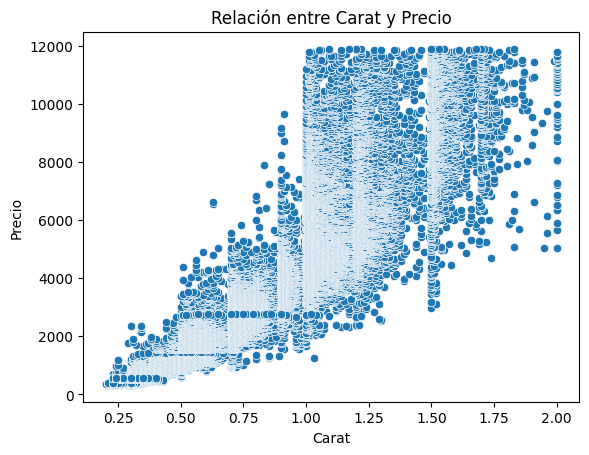

In [8]:
# Histograma: nos ayuda a ver c√≥mo est√°n distribuidos los precios
plt.figure(figsize=(10, 5))
df['price'].hist(bins=50)
plt.title('Distribuci√≥n del Precio')
plt.xlabel('Precio del diamante (USD)')
plt.ylabel('Cantidad de diamantes')
plt.show()

# Scatterplot (dispersi√≥n): vemos c√≥mo se relacionan el peso (carat) y el precio
sns.scatterplot(x='carat', y='price', data=df)
plt.title('Relaci√≥n entre Carat y Precio')
plt.xlabel('Carat')
plt.ylabel('Precio')
plt.show()


## Interpretaci√≥n de gr√°ficos: Precio y Carat

### 1. Distribuci√≥n del Precio

El histograma muestra que la mayor√≠a de los diamantes tienen un precio entre **500 y 2000 USD**.  
A medida que aumenta el precio, la cantidad de diamantes disminuye bruscamente.  
Esto indica una **distribuci√≥n sesgada a la derecha**, lo cual es com√∫n en precios: hay pocos diamantes extremadamente caros y muchos en el rango m√°s bajo.

> La mayor√≠a de los diamantes en el mercado est√°n en un rango de precio accesible, y solo una minor√≠a son de lujo.

---

### 2. Relaci√≥n entre Carat y Precio

El gr√°fico de dispersi√≥n muestra una **relaci√≥n positiva clara** entre el peso (carat) y el precio.  
Es decir, **a mayor carat, mayor precio**. Sin embargo, la relaci√≥n **no es lineal**: el precio parece aumentar m√°s r√°pido a medida que el carat crece (relaci√≥n exponencial).

> Esto confirma que `carat` es la variable m√°s influyente en el precio del diamante, pero tambi√©n que el incremento de precio es m√°s fuerte en carats altos.


Heatmap de correlaci√≥n num√©rica

In [10]:
# El mapa de calor muestra qu√© variables num√©ricas est√°n m√°s correlacionadas entre s√≠.
# Cuanto m√°s cerca de 1 o -1, m√°s fuerte es la relaci√≥n.

# Seleccionamos solo las columnas num√©ricas para calcular la correlaci√≥n
numericas_df = df.select_dtypes(include=['float64', 'int64'])

# Ahora s√≠ generamos el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(numericas_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlaci√≥n entre variables num√©ricas')
plt.show()


## Correlaci√≥n entre variables num√©ricas

- `carat` es la variable m√°s fuertemente correlacionada con `price` (0.92), seguida de las dimensiones `x`, `y` y `z`.
- `depth` y `table` tienen correlaci√≥n **muy baja o negativa**, por lo que aportan poco al modelo.
- `x`, `y` y `z` est√°n altamente correlacionadas entre s√≠ (>0.95), lo que indica **redundancia**.




Relaci√≥n entre variables categ√≥ricas y precio

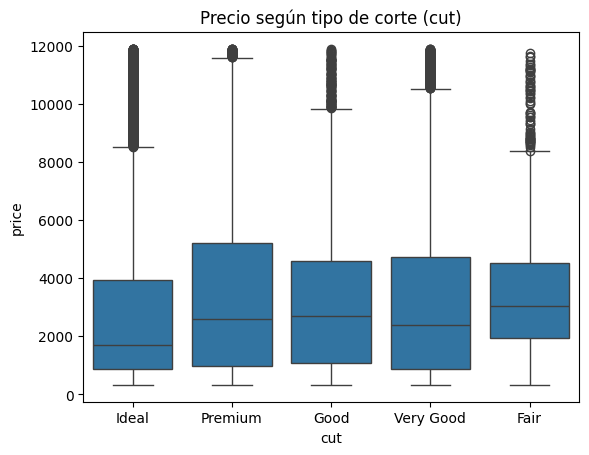

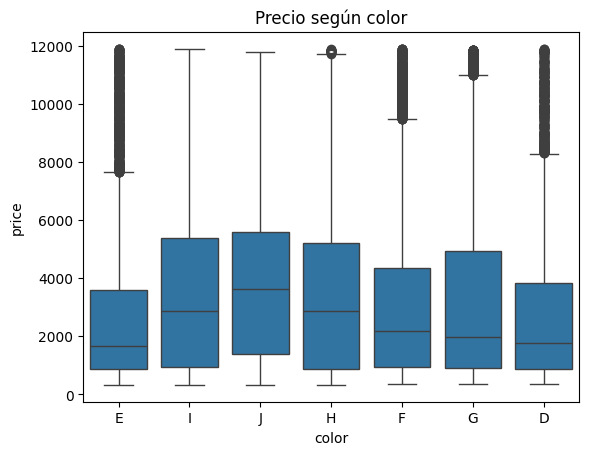

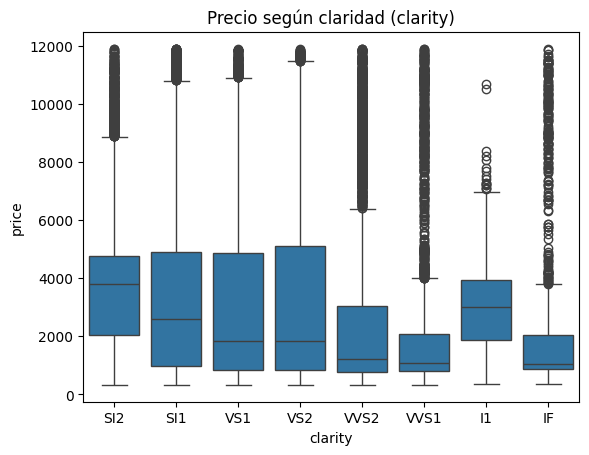

In [11]:
# Los siguientes gr√°ficos nos permiten ver c√≥mo cambia el precio seg√∫n el tipo de corte, color y claridad

sns.boxplot(x='cut', y='price', data=df)
plt.title('Precio seg√∫n tipo de corte (cut)')
plt.show()

sns.boxplot(x='color', y='price', data=df)
plt.title('Precio seg√∫n color')
plt.show()

sns.boxplot(x='clarity', y='price', data=df)
plt.title('Precio seg√∫n claridad (clarity)')
plt.show()


## An√°lisis de precio seg√∫n variables categ√≥ricas

---

### 1. Precio seg√∫n tipo de corte (`cut`)

**Interpretaci√≥n:**
- Aunque el corte **Ideal** es el m√°s frecuente, no tiene el precio promedio m√°s alto.
- El corte **Premium** muestra una **mediana de precio m√°s elevada** que el resto.
- Los cortes **Good**, **Very Good** y **Fair** tienen precios similares, siendo **Fair** el m√°s bajo en tendencia.

**Resumen:**  
El tipo de corte influye, pero **no es el √∫nico determinante del precio**. Un corte de mejor calidad no garantiza autom√°ticamente un precio m√°s alto, ya que **interact√∫a con otras variables** como el peso (`carat`) o la claridad (`clarity`).

---

### 2. Precio seg√∫n color (`color`)

**Interpretaci√≥n:**
- Las letras representan la calidad del color del diamante (**D es el m√°s puro**, **J el menos puro**).
- La mediana de precio **no var√≠a dr√°sticamente** entre colores.
- Colores **I, J y H** tienen precios medianos ligeramente m√°s altos que **D o E**, lo cual es **contraintuitivo**.

**Resumen:**  
Aunque el color es relevante, **no presenta una correlaci√≥n fuerte** con el precio. Diamantes con colores de menor calidad podr√≠an estar **compensados por mayor tama√±o** (`carat`), afectando as√≠ el precio final.

---

### 3. Precio seg√∫n claridad (`clarity`)

**Interpretaci√≥n:**
- Categor√≠as como **IF** (internally flawless) y **VVS1**, que deber√≠an tener precios altos, muestran **medianas m√°s bajas**.
- Claridades **SI2** y **SI1** (menor calidad) presentan los **precios m√°s altos** en promedio.
- Esto indica que otras variables, como el **peso** o el **corte**, influyen m√°s.

**Resumen:**  
La claridad **no determina por s√≠ sola el precio**. Algunos diamantes con claridad baja pueden tener mayor peso o un corte mejor, lo que **compensa su defecto visual** y eleva su valor.

---


## Data Transformation

Codificaci√≥n de variables categ√≥ricas

In [12]:
# Los modelos no pueden trabajar directamente con texto. Por eso usamos "one-hot encoding":
# creamos una nueva columna para cada valor categ√≥rico.

df_encoded = pd.get_dummies(df, columns=['cut', 'color', 'clarity'], drop_first=True)

Normalizaci√≥n de variables num√©ricas

In [13]:
# Algunas variables num√©ricas tienen escalas muy diferentes (por ejemplo: carat vs depth).
# Normalizarlas ayuda a que ciertos modelos (como regresi√≥n lineal o KNN) funcionen mejor.

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numericas = ['carat', 'depth', 'table', 'x', 'y', 'z']
df_encoded[numericas] = scaler.fit_transform(df_encoded[numericas])

## Feature Selection - Selecci√≥n de variables

Ver qu√© variables se relacionan m√°s con el precio

In [14]:
# Aqu√≠ vemos qu√© variables tienen m√°s correlaci√≥n con el precio
# Esto nos da pistas de cu√°les ser√°n m√°s √∫tiles para el modelo

correlaciones = df_encoded.corr()['price'].sort_values(ascending=False)
print("Correlaciones con el precio:")
print(correlaciones)

Correlaciones con el precio:
price            1.000000
carat            0.918808
x                0.894336
y                0.889809
z                0.867677
table            0.125046
clarity_SI2      0.101961
cut_Premium      0.078356
color_I          0.062896
color_J          0.060784
color_H          0.060588
clarity_SI1      0.030602
cut_Very Good    0.017571
color_G          0.017163
cut_Good         0.013311
clarity_VS1      0.003666
depth            0.000205
clarity_VS2     -0.003897
color_F         -0.009857
clarity_VVS2    -0.040900
clarity_IF      -0.068236
color_E         -0.091223
cut_Ideal       -0.099920
clarity_VVS1    -0.101628
Name: price, dtype: float64


## Interpretaci√≥n: Correlaciones con el precio

La correlaci√≥n indica cu√°nto se relacionan dos variables:

- **+1** ‚Üí correlaci√≥n positiva perfecta (cuando una sube, la otra tambi√©n).
- **‚Äì1** ‚Üí correlaci√≥n negativa perfecta (cuando una sube, la otra baja).
- **0** ‚Üí sin relaci√≥n lineal.

---

### Variables m√°s correlacionadas positivamente con `price`

| Variable       | Correlaci√≥n | Explicaci√≥n                                                                 |
|----------------|-------------|-----------------------------------------------------------------------------|
| **carat**       | 0.9188      | Fuerte relaci√≥n positiva. A mayor peso, mayor precio.                       |
| **x, y, z**     | ~0.89       | Dimensiones f√≠sicas. Relacionadas con el tama√±o, que influye directamente en el precio. |
| **clarity_SI2** | 0.1019      | Claridad baja, pero posiblemente asociada a mayor tama√±o y por eso m√°s cara. |

> Estas variables (especialmente `carat`) son las m√°s √∫tiles para predecir el precio.

---

### Variables con baja o negativa correlaci√≥n con `price`

| Variable           | Correlaci√≥n | Interpretaci√≥n                                                             |
|--------------------|-------------|----------------------------------------------------------------------------|
| **cut_Premium**     | 0.078       | Ligera influencia positiva.                                               |
| **cut_Ideal**       | -0.099      | Correlaci√≥n levemente negativa. Posiblemente los diamantes "Ideal" tienden a ser m√°s peque√±os. |
| **clarity_VVS1/VS1/IF** | ~0 o negativo | Sorprendentemente, tener claridad superior no garantiza un precio mayor. |
| **depth / table**   | ~0          | Pr√°cticamente sin relaci√≥n con el precio.                                 |

> üîç Las caracter√≠sticas cualitativas como el corte, color o claridad **no tienen un efecto lineal claro** sobre el precio por s√≠ solas.

---

##Entrenamiento y evaluaci√≥n de modelos de regresi√≥n

## Paso 1: Separaci√≥n de variables predictoras y objetivo

Separamos `price` como variable dependiente (`y`) y el resto como variables independientes (`X`).
Dividimos los datos en conjunto de entrenamiento y prueba (80/20).


In [18]:
X = df_encoded.drop(columns='price')
y = df_encoded['price']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Paso 2: Entrenamiento de modelo base - Regresi√≥n Lineal

Entrenamos un modelo de regresi√≥n lineal para usarlo como l√≠nea base de comparaci√≥n.


In [19]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

## Paso 3: Entrenamiento de modelo alternativo - Random Forest

Entrenamos un modelo de Random Forest, que suele ser m√°s robusto frente a no linealidades y variables categ√≥ricas.


In [20]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

## Paso 4: Evaluaci√≥n de los modelos

Calculamos las m√©tricas de evaluaci√≥n de regresi√≥n:
- **MSE** (error cuadr√°tico medio)
- **RMSE** (ra√≠z del MSE)
- **R¬≤** (coeficiente de determinaci√≥n)

Comparamos ambos modelos.


In [22]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluar(nombre, y_real, y_pred):
    mse = mean_squared_error(y_real, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_real, y_pred)
    print(f" {nombre}")
    print(f" - MSE : {mse:.2f}")
    print(f" - RMSE: {rmse:.2f}")
    print(f" - R¬≤  : {r2:.4f}\n")

evaluar("Regresi√≥n Lineal", y_test, y_pred_lr)
evaluar("Random Forest", y_test, y_pred_rf)

 Regresi√≥n Lineal
 - MSE : 554369.60
 - RMSE: 744.56
 - R¬≤  : 0.9246

 Random Forest
 - MSE : 168162.68
 - RMSE: 410.08
 - R¬≤  : 0.9771



## Interpretaci√≥n de los resultados del modelo

### Regresi√≥n Lineal
- **MSE**: 554,370  
- **RMSE**: 744.56  
- **R¬≤**: 0.9246

El modelo lineal explica el **92% de la variaci√≥n del precio**, pero tiene un **error promedio de $745**, lo cual indica que puede ser impreciso en valores altos o bajos.

---

### Random Forest
- **MSE**: 168,163  
- **RMSE**: 410.08  
- **R¬≤**: 0.9771

El modelo Random Forest tiene **mucho menor error** y un **R¬≤ m√°s alto (97.7%)**, lo que significa que es **m√°s preciso y generaliza mejor** que la regresi√≥n lineal.

---

### Conclusiones
Random Forest es claramente superior:  
- Menor error (RMSE m√°s bajo)  
- Mayor capacidad explicativa (R¬≤ m√°s alto)  
Es el mejor modelo para predecir el precio de los diamantes en este caso.



## Paso 5: Ajuste de hiperpar√°metros para Random Forest

Utilizamos GridSearchCV para encontrar mejores combinaciones de `n_estimators` y `max_depth`.


In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid,
                    cv=3, scoring='neg_mean_squared_error')

grid.fit(X_train, y_train)

print("‚úÖ Mejores par√°metros para Random Forest:")
print(grid.best_params_)


‚úÖ Mejores par√°metros para Random Forest:
{'max_depth': 20, 'n_estimators': 200}


## Interpretaci√≥n: Mejores par√°metros para Random Forest

El ajuste con GridSearchCV encontr√≥ que los mejores hiperpar√°metros para este modelo son:

- **n_estimators = 200**: el modelo usa 200 √°rboles, lo que mejora la precisi√≥n respecto al valor por defecto (100).
- **max_depth = 20**: limita la profundidad m√°xima de cada √°rbol, lo que ayuda a evitar sobreajuste.

Con estos valores, el modelo logra **mayor precisi√≥n y mejor generalizaci√≥n**, reduciendo el error en las predicciones.


## Paso 6: Visualizaci√≥n de resultados

Graficamos los valores predichos por el modelo Random Forest frente a los valores reales.
Una buena predicci√≥n deber√≠a acercarse a la l√≠nea diagonal (roja).


In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Precio real')
plt.ylabel('Precio predicho')
plt.title('Random Forest: Precio real vs predicho')
plt.show()

## Interpretaci√≥n: Precio real vs predicho (Random Forest)

- Cada punto representa un diamante.
- El eje X muestra el **precio real**, y el eje Y el **precio predicho** por el modelo.
- La **l√≠nea roja** representa la predicci√≥n perfecta (precio real = predicho).

La mayor√≠a de los puntos est√°n alineados y cerca de la l√≠nea roja, lo que indica que:
- El modelo tiene **alta precisi√≥n**.
- Predice correctamente tanto para precios bajos como altos.
- Solo hay algunos errores dispersos, especialmente en precios muy altos.

El modelo Random Forest logra una **buena capacidad predictiva** y generaliza bien sobre el conjunto de prueba.


## Paso 7: Guardar modelo entrenado (serializaci√≥n)

Guardamos el modelo final de Random Forest en un archivo `.pkl` usando `pickle`.
Esto permite usarlo luego en una API o script de predicci√≥n.


In [25]:
import pickle

with open('modelo_rf.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

print("Modelo serializado exitosamente: modelo_rf.pkl")

Modelo serializado exitosamente: modelo_rf.pkl
